In [1]:
!pip install torchviz torchinfo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision  import transforms, datasets

In [4]:
## matplot default
plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ":"
plt.rcParams['axes.unicode_minus'] = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Convolutional Neural network
- 합성곱 신경망

In [5]:
data_root = "./data"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # [784]
])

train_set = datasets.MNIST(
    root = data_root,
    train = True,
    transform = transform,
    download = True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.18MB/s]


In [9]:
print(len(train_set))

image, label = train_set[0]
print(image.shape)
print(label)

60000
torch.Size([1, 28, 28])
5


In [31]:
## Conv class
conv1 = nn.Conv2d(in_channels= 1, out_channels=1, kernel_size= 3, stride = 1, padding = 0)
print("conv1 weight shape = \n", conv1.weight.shape)
print("conv1 bias shape = \n", conv1.bias)

print()
result = conv1(image.view(1, 1, 28, 28)) # batch, channel, height, width
print(result.shape)

conv1 weight shape = 
 torch.Size([1, 1, 3, 3])
conv1 bias shape = 
 Parameter containing:
tensor([-0.3128], requires_grad=True)

torch.Size([1, 1, 26, 26])


In [32]:
## conv1
image, label = train_set[0]
print(image.shape)
image = image.view(1, 1, 28, 28)
print(image.shape)

w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)

print("w1 shape = ", w1.shape)
print("w2 shape = ", w2.shape)
print("w3 shape = ", w3.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
w1 shape =  torch.Size([1, 1, 26, 26])
w2 shape =  torch.Size([1, 1, 24, 24])
w3 shape =  torch.Size([1, 1, 22, 22])


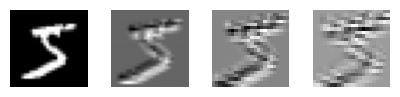

In [33]:
images = [image, w1, w2, w3]
plt.figure(figsize=(5, 1))
for i in range(4):
  # size = (28 - i*2)
  ax = plt.subplot(1, 4, i+1)
  img = images[i].data.numpy() # tensor => numpy
  plt.imshow(img.squeeze(), cmap = "gray") # [1, 1, 28, 28] => [28, 28]
  plt.axis("off")

plt.show()

## nn.Conv2d, nn.MaxPool2d

In [55]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

print("conv1 weight shape = ", conv1.weight.shape)
print("conv1 bias shape = ", conv1.bias.shape)

print("conv2 weight shape = ", conv2.weight.shape)
print("conv2 bias shape = ", conv2.bias.shape)

conv1 weight shape =  torch.Size([32, 3, 3, 3])
conv1 bias shape =  torch.Size([32])
conv2 weight shape =  torch.Size([32, 32, 3, 3])
conv2 bias shape =  torch.Size([32])


torch.Size([100, 3, 32, 32])


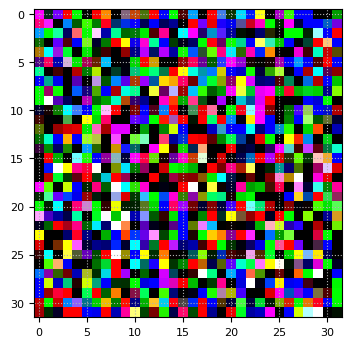

In [54]:
##
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

# inputs[0].permute(1, 2, 0).shape
plt.imshow(inputs[0].permute(1, 2, 0))
plt.show()

In [61]:
##
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

print(inputs.shape)
print("x1 = ", x1.shape)
print("x2 = ",x2.shape)
print("x3 = ",x3.shape)
print("x4 = ",x4.shape)
print("x5 = ",x5.shape)

torch.Size([100, 3, 32, 32])
x1 =  torch.Size([100, 32, 30, 30])
x2 =  torch.Size([100, 32, 30, 30])
x3 =  torch.Size([100, 32, 28, 28])
x4 =  torch.Size([100, 32, 28, 28])
x5 =  torch.Size([100, 32, 14, 14])


## nn.Sequential

In [63]:
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


## nn.Flatten

In [65]:
flatten = nn.Flatten()
outputs = flatten(outputs)

print(outputs.shape)

torch.Size([100, 6272])


## fit (학습)

In [70]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
  from tqdm.notebook import tqdm

  for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    test_acc, test_loss = 0, 0

    ### train
    net.train() # dropout, batch normalization

    for inputs, labels in tqdm(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      ## pred
      outputs = net(inputs)
      ## cost
      loss = criterion(outputs, labels)

      ## learning
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      predicted = torch.argmax(outputs, 1)
      acc_train = (predicted == labels).float().mean()

      train_acc += acc_train.item()
      train_loss += loss.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)

  #### test
    net.eval()

    for inputs_test, labels_test in test_loader:
      inputs_test = inputs_test.to(device)
      labels_test = labels_test.to(device)

      outputs_test = net(inputs_test)
      loss_test = criterion(outputs_test, labels_test)

      predicted_test = torch.argmax(outputs_test, 1)
      acc_test = (predicted_test == labels_test).float().mean()

      test_acc += acc_test.item()
      test_loss += loss_test.item()

    test_acc /= len(test_loader)
    test_loss /= len(test_loader)

    print(f"Epoch = {epoch}, Train loss ={train_loss:.3f}, Train acc = {train_acc:.3f}")
    print(f"                 Test loss ={test_loss:.3f}, Train acc = {test_acc:.3f}")
    item = np.array([epoch, train_loss, train_acc, test_loss, test_acc])
    history = np.vstack([history, item])

  return history


In [71]:
## eval-history
def evaluate_history(history):
  print("test 결과")
  print(f"초기상태 : 손실 :{history[0, 3]}, 정확도: {history[0, -1]}")
  print(f"최종상태 : 손실 :{history[-1, 3]}, 정확도: {history[-1, -1]}")

  num_epochs = len(history)
  unit = num_epochs /10

  plt.figure(figsize=(9, 8))
  plt.plot(history[:, 0], history[:, 1], 'b', label = "Train")
  plt.plot(history[:, 0], history[:, 3], 'k', label = "Test")
  plt.xticks(np.arange(0, num_epochs+1, unit))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("CELoss vs Epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(9, 8))
  plt.plot(history[:, 0], history[:, 2], 'b', label = "Train")
  plt.plot(history[:, 0], history[:, 4], 'k', label = "Test")
  plt.xticks(np.arange(0, num_epochs+1, unit))
  plt.xlabel("Epoch")
  plt.ylabel("ACC")
  plt.title("ACC vs Epoch")
  plt.legend()
  plt.show()

In [92]:
## 이미지 레이블
def show_images_labels(loader, classes, net = None, device = "cpu"):
  for images, labels in loader:
    break

  n_size = min(len(images), 50)
  print("n_size = ", n_size)

  if net is not None:
    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    predicted = torch.argmax(outputs, 1)

  plt.figure(figsize = (20, 15))
  for i in range(n_size):
    ax = plt.subplot(5, 10, i+1)
    label_name = classes[labels[i]]

    if net is not None:
      predicted_name = classes[predicted[i]]

      if label_name == predicted_name:
        c = "k"
      else:
        c = 'b'
      plt.title(f"{label_name}:{predicted_name}", c = c, fontsize = 20)

    else:
      plt.title(f"{label_name}", fontsize = 20)

    image_np = images[i].data.permute(1, 2, 0).numpy()
    image = image_np # tensor dim =/ numpy dim

    image = (image + 1)/2
    plt.imshow(image)
    plt.axis("off")

  plt.show()

In [73]:
def torch_seed(seed = 123):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [75]:
##
### Linear
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x:x.view(-1))
])

## CNN
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [77]:
# data_root
train_set1 = datasets.CIFAR10(
    root = data_root,
    train = True,
    transform = transform1,
    download = True
)

test_set1 = datasets.CIFAR10(
    root = data_root,
    train = False,
    transform = transform1,
    download = True
)

train_set2 = datasets.CIFAR10(
    root = data_root,
    train = True,
    transform = transform2,
    download = True
)

test_set2 = datasets.CIFAR10(
    root = data_root,
    train = False,
    transform = transform2,
    download = True
)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


In [83]:
images1, labels1 = train_set1[0] # Linear model
images2, labels2 = train_set2[0] # CNN model

print(images1.shape)
print(images2.shape)

print(len(train_set1))
print(len(train_set2))

torch.Size([3072])
torch.Size([3, 32, 32])
50000
50000


In [84]:
from torch.utils.data import DataLoader

In [85]:
## batch
batch_size = 100

### Linear
train_loader1 = DataLoader(
    train_set1,
    batch_size,
    True
)

test_loader1 = DataLoader(
    test_set1,
    batch_size,
    True
)

### CNN
train_loader2 = DataLoader(
    train_set2,
    batch_size,
    True
)

test_loader2 = DataLoader(
    test_set2,
    batch_size,
    True
)

n_size =  50


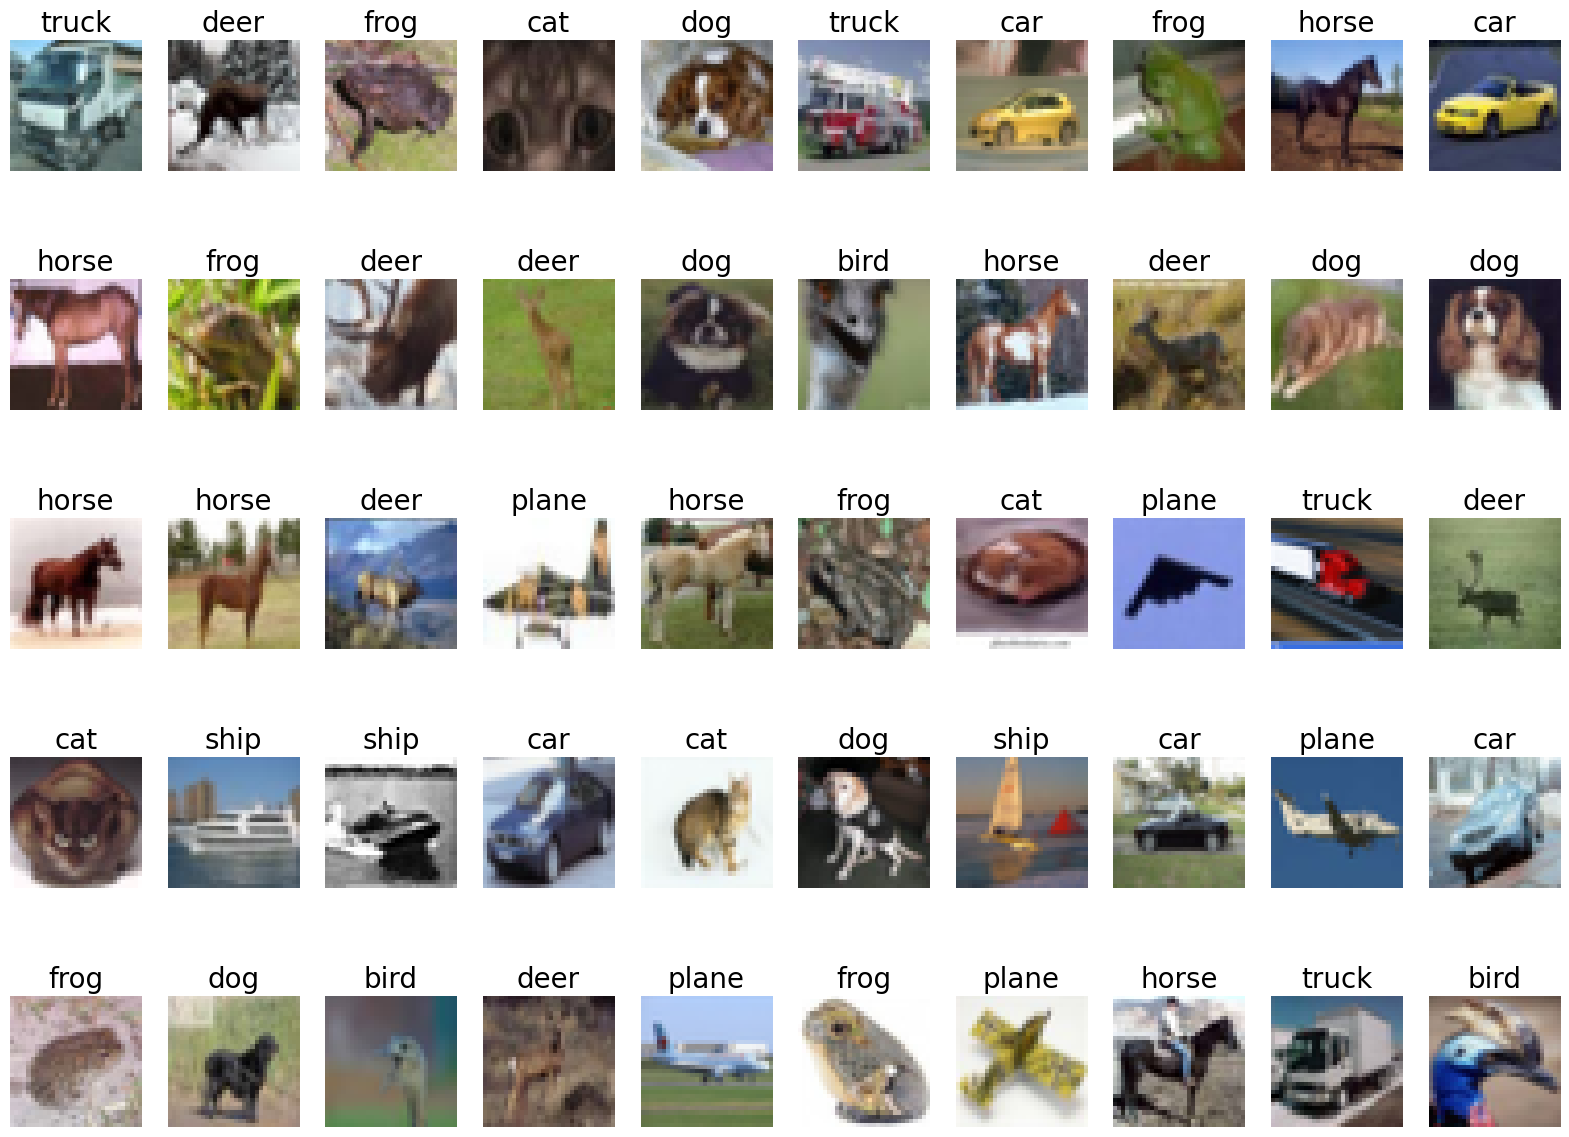

In [93]:
# def show_images_labels(loader, classes, net = None, device = "cpu"):
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
show_images_labels(test_loader2, classes)